In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib widget

# Load experiment list

In [5]:
data_dir = Path(r"P:\\")
plotsavedir = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\THstim_project\THactivation")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,tiparea,dist_CL,color
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300,TH,0.925338,tomato
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300,CP,1.494992,firebrick
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,1.286954,limegreen
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,1.435270,forestgreen
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,0.686477,violet


# Test one session

In [16]:
choose_sub = 6
exprow = all_subexp.iloc[choose_sub]
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
exp_tag = exprow.exp_folder[:9]
print(exp_tag)

Experiment type: electrical stimulation
THstim_d1


In [17]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
else:
    print('Stim electrode location file not found.')

In [18]:
print(stim_elec_data['tip']['area'])

DG-po


## Load all data

### Stim log

In [9]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [10]:
simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
if os.path.exists(simple_log_file):
    simple_log = pd.read_csv(simple_log_file)
elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
    simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
else:
    print('No simple log found')

In [11]:
simple_log

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,50,20,2320.34197,2340.34208,0
1,freq50Hz,50,20,2486.19348,2506.19359,0
2,freq50Hz,100,20,2585.67013,2605.67024,0
3,freq100Hz,50,20,2724.17095,2744.17105,0
4,freq100Hz,100,20,2837.27795,2857.27805,0
5,freq50Hz,30,20,3054.06783,3074.06793,1
6,freq50Hz,50,20,3155.39423,3175.39434,1
7,freq50Hz,50,20,3395.78621,3415.78632,1
8,freq50Hz,50,20,3551.69760,3571.69771,1
9,freq50Hz,100,20,3665.24847,3685.24858,1


### Iso times

### Pupil

### Running

### Load probe LFP

In [12]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeD', 'probeE', 'probeF']


In [13]:
for probei in probe_list:
    print(probei)
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    probe_areas = np.array(data['area_ch'])
    print(np.unique(probe_areas))
    print('')

probeD
['APN' 'HPF' 'MB' 'MRN' 'POST' 'SCig' 'SUB' 'VISp1' 'VISp2/3' 'VISp4'
 'VISp5' 'VISp6a' 'VISp6b' 'alv' 'bsc' 'dhc' 'fp' 'null' 'or' 'root']

probeE
['CA1' 'CA3' 'DG-mo' 'DG-po' 'DG-sg' 'Eth' 'LP' 'PF' 'SSp-bfd1'
 'SSp-bfd2/3' 'SSp-bfd4' 'SSp-bfd5' 'SSp-bfd6a' 'SSp-bfd6b' 'alv' 'ccs'
 'null' 'or' 'root']

probeF
['ACAd5' 'ACAv2/3' 'ACAv5' 'LSr' 'MOs1' 'MOs2/3' 'MOs5' 'STR' 'ccb' 'ccg'
 'null']



In [14]:
probe_name = 'probeE'

## Load LFP as memmap ##
# lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
# lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
#     (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

## Load probe_info.json ##
with open(exp.ephys_params[probe_name]['probe_info']) as data_file:
    data = json.load(data_file)
npx_allch = np.array(data['channel'])
surface_ch = int(data['surface_channel'])
allch_z = np.array(data['vertical_pos'])
ref_mask = np.array(data['mask'])
npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
probe_ch_depths = allch_z[surface_ch] - allch_z
probe_areas = np.array(data['area_ch'])

In [15]:
area_chs = np.nonzero(probe_areas == 'PO')[0]
print(area_chs)

[]


## Collect LFP from thalamic areas

Get the total LFP and timestamps, apply bandpass filter, downsample, store in dict.

In [16]:
mcc = MouseConnectivityCache(resolution=25)
str_tree = mcc.get_structure_tree()

In [17]:
THmask = np.zeros((len(probe_areas)), dtype=bool)
for ii, areai in enumerate(probe_areas):
    try:
        reg_id = str_tree.get_structures_by_acronym([areai])[0]['id']
        THmask[ii] = str_tree.structure_descends_from(reg_id, 1129)
    except:
        continue

In [18]:
THchs = npx_allch[ref_mask * THmask]
print(len(THchs))

144


In [19]:
probe_areas[THchs]

array(['VAL', 'VAL', 'VAL', 'VAL', 'VAL', 'VAL', 'VAL', 'VAL', 'VAL',
       'VAL', 'VAL', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO',
       'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO',
       'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO',
       'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO',
       'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO',
       'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO',
       'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'PO', 'LD',
       'PO', 'PO', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD',
       'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD',
       'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD',
       'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD',
       'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD', 'LD',
       'LD', 'LD', 'LD'], dtype='<U10')

In [20]:
## get area labels ##
area_boundaries = []
area_labels = []
last_area = ''
for ai, area in enumerate(probe_areas[THchs]):
    if area != last_area:
        area_boundaries.append(ai)
        area_labels.append(area)
        last_area = area
area_boundaries.append(ai)
label_locs = area_boundaries[:-1] + np.diff(area_boundaries)/2

In [21]:
## Load LFP as memmap ##
lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
    (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

In [22]:
pdelta = [-0.1, 0.1] # plot before and after, s
event_ts = np.arange(pdelta[0], pdelta[1], 1/exp.ephys_params[probe_name]['lfp_sample_rate'])
LFP_traces = []
for evind, eventrow in simple_log.iterrows():
    pwindow = [eventrow.onset + pdelta[0], eventrow.onset + pdelta[1]]
    timeinds = np.nonzero((lfp_ts > pwindow[0]) & (lfp_ts < pwindow[1]))[0]
    LFP_traces.append(lfp_data_mm[timeinds, :][:, THchs])
LFP_event_traces = np.array(LFP_traces) * exp.ephys_params[probe_name]['bit_volts']
print(LFP_event_traces.shape)
baselinesub_LFP = LFP_event_traces - np.mean(LFP_event_traces[:, event_ts < 0, :], axis=1)[:, None, :]

(20, 500, 144)


In [23]:
LFP_EP = np.mean(baselinesub_LFP, axis=0)
print(LFP_EP.shape)
print(np.min(LFP_EP))
print(np.max(LFP_EP))

(500, 144)
-1037.4705806772909
1108.6911842629481


In [24]:
print(np.min(baselinesub_LFP))
print(np.max(baselinesub_LFP))

-1782.8500398406375
2641.881752988047


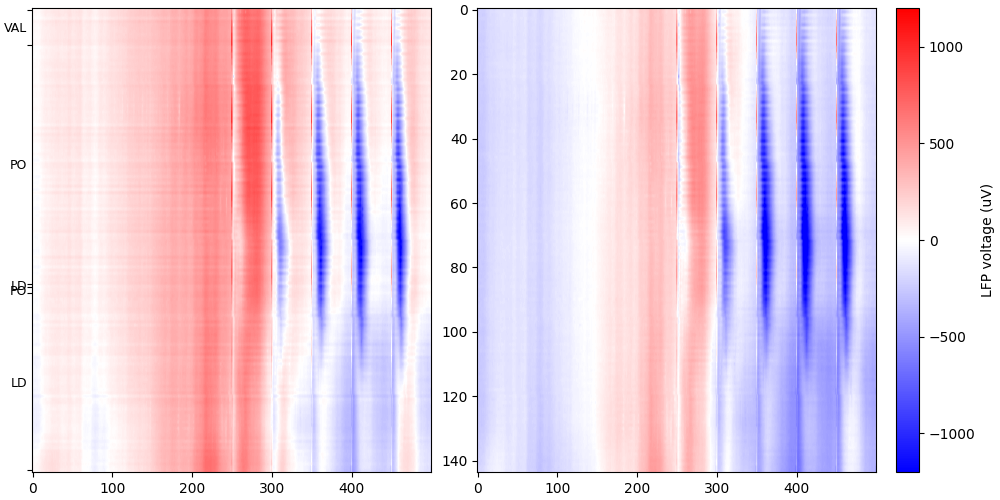

In [25]:
plot_event = 4
vlevel = 1200
fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
axs[0].imshow(LFP_event_traces[plot_event, :, :].T, interpolation=None, cmap='bwr', aspect='auto', vmin=-vlevel, vmax=vlevel)
lfpim = axs[1].imshow(baselinesub_LFP[plot_event, :, :].T, interpolation=None, cmap='bwr', aspect='auto', vmin=-vlevel, vmax=vlevel)
axs[0].set_yticks(area_boundaries)
axs[0].set_yticklabels('')
axs[0].set_yticks(label_locs, minor=True)
axs[0].set_yticklabels(area_labels, minor=True, fontsize=9)
axs[0].tick_params(which='minor', length=0)
fig.colorbar(lfpim, ax=axs[1], label='LFP voltage (uV)')

Text(0.5, 1.0, 'Event 4')

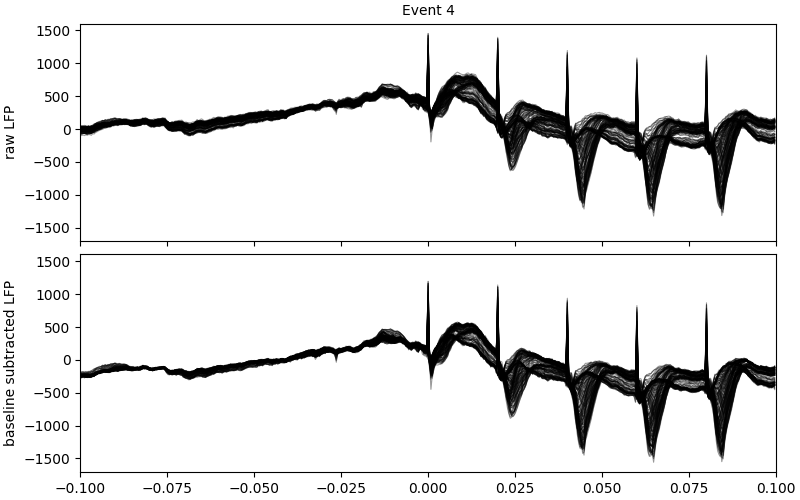

In [26]:
# plot_event = 7
fig, axs = plt.subplots(2, 1, figsize=(8, 5), constrained_layout=True, sharex=True, sharey=True)
axs[0].plot(event_ts, LFP_event_traces[plot_event, :, :], color='k', linewidth=0.8, alpha=0.4)
axs[0].set_ylabel('raw LFP')
axs[1].plot(event_ts, baselinesub_LFP[plot_event, :, :], color='k', linewidth=0.8, alpha=0.4)
axs[1].set_ylabel('baseline subtracted LFP')
axs[0].set_xlim(pdelta)
axs[0].set_title('Event {:d}'.format(plot_event))

Plot the EP for all chs

(-0.1, 0.1)

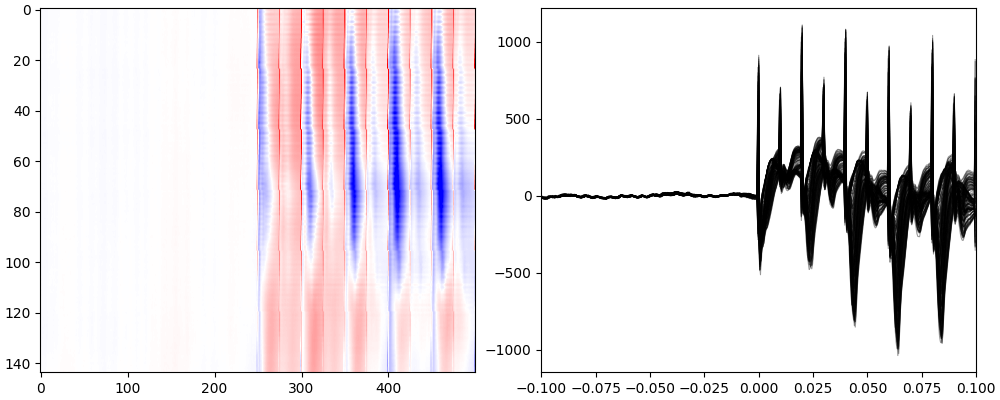

In [27]:
vlevel = 800
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
axs[0].imshow(LFP_EP.T, interpolation=None, cmap='bwr', aspect='auto', vmin=-vlevel, vmax=vlevel)
axs[1].plot(event_ts, LFP_EP, color='k', linewidth=0.8, alpha=0.4)
axs[1].set_xlim(pdelta)

## Plot all trials: LFP traces

In [28]:
len(simple_log)

20

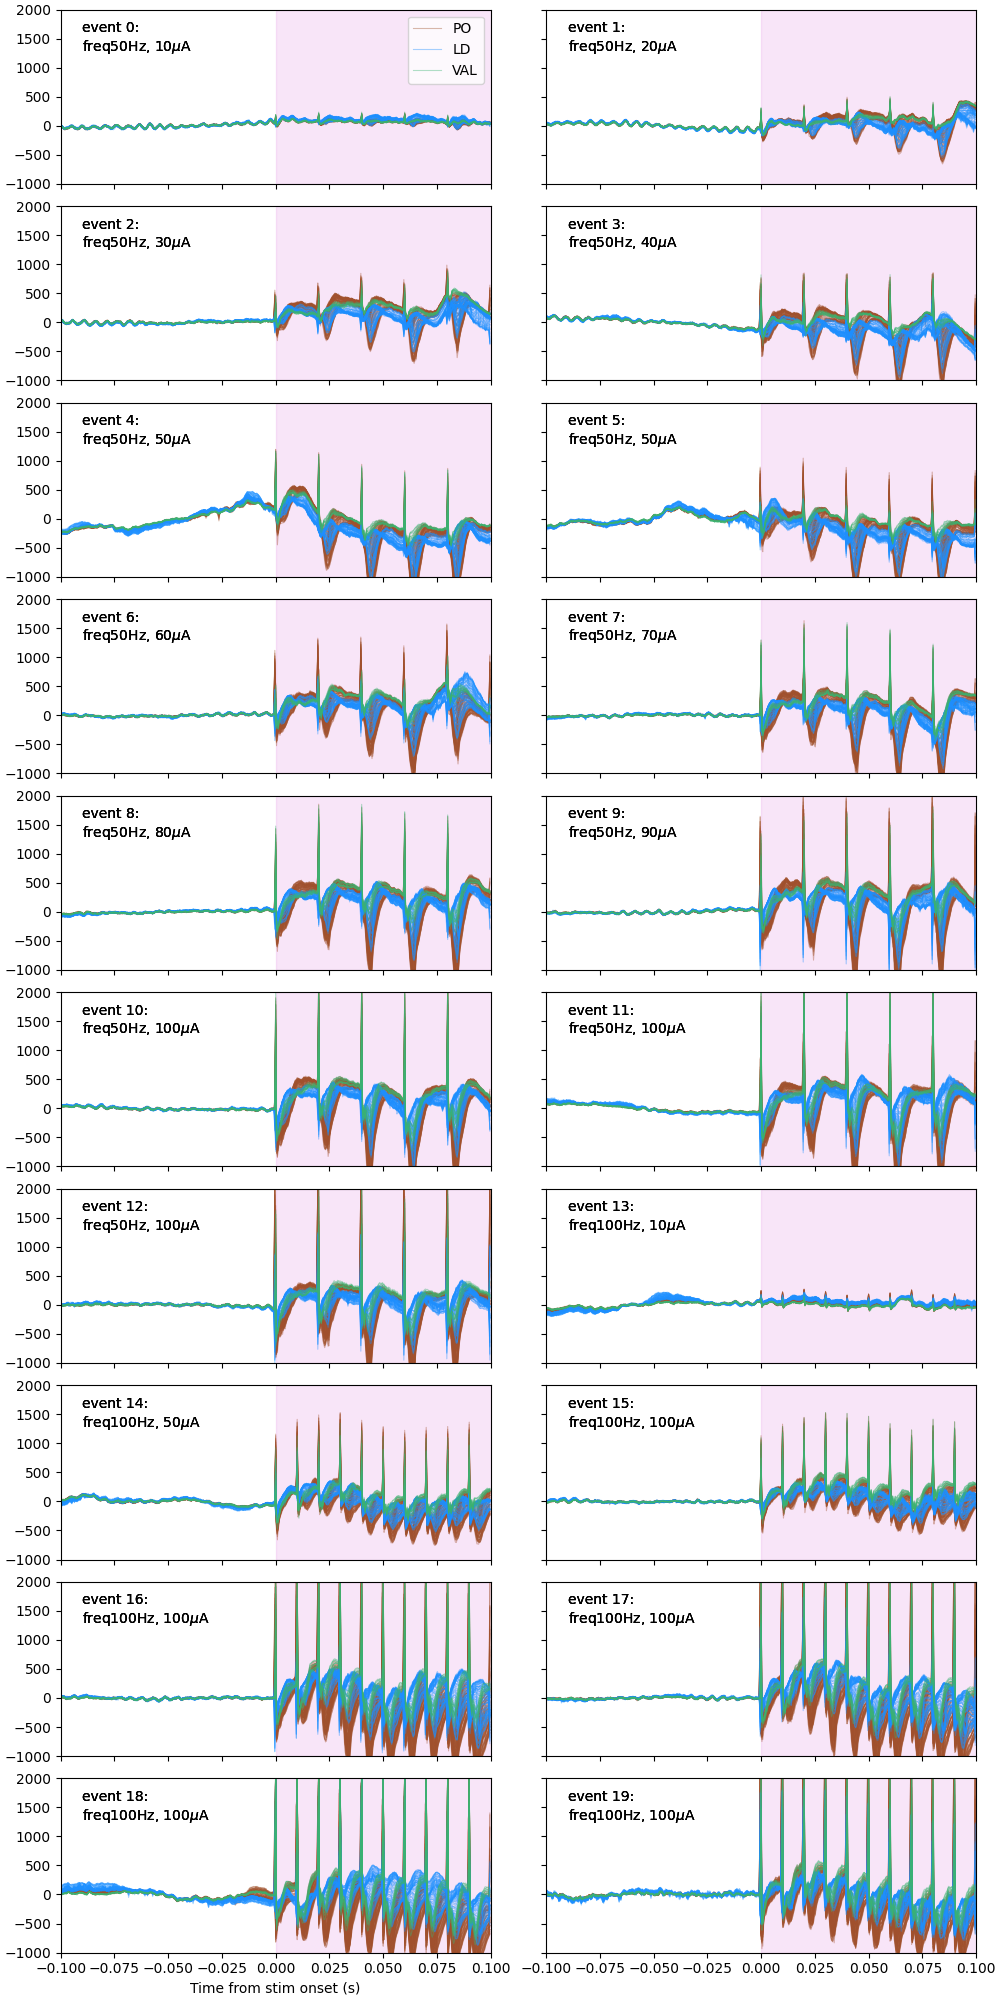

In [29]:
plot_regions = {
    # 'LGd-co': 'mediumseagreen',
    # 'LP': 'deeppink',
    'PO': 'sienna',
    # 'alv': 'coral',
    # 'PF': 'dodgerblue',
    'LD': 'dodgerblue',
    'VAL': 'mediumseagreen',
}

fig, axs = plt.subplots(10, 2, figsize=(10,20), constrained_layout=True, sharex=True, sharey=True)
for ax, (indi, eventrow) in zip(axs.flatten(), simple_log.iterrows()):
    ax.axvspan(0, eventrow.duration, color='m', alpha=0.1)
    leglabels = []
    legs = []
    for regi, rcol in plot_regions.items():
        line = ax.plot(event_ts, baselinesub_LFP[indi, :, :][:, probe_areas[THchs] == regi], color=rcol, linewidth=0.8, alpha=0.4)
        ax.annotate(
            'event {:d}:\n{}, {:d}$\mu$A'.format(indi, eventrow.stim_type, eventrow.parameter), xy=(-0.09, 1800), xycoords='data', va='top', ha='left')
        leglabels.append('{}'.format(regi))
        legs.append(line[0])
#     ax.set_ylabel('Pop. firing rate (Hz)')
axs[-1,0].set_xlabel('Time from stim onset (s)')
axs[0,0].set_xlim(pdelta)
axs[0,0].set_ylim([-1000, 2000])
axs[0,0].legend(legs, leglabels, loc='upper right')

### SAVE ###
fig_name = '{}{}_THevokedLFP_alltrials.png'.format(exp.mouse, exp_tag)
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

## Plot the average EP across all trials of the same frequency

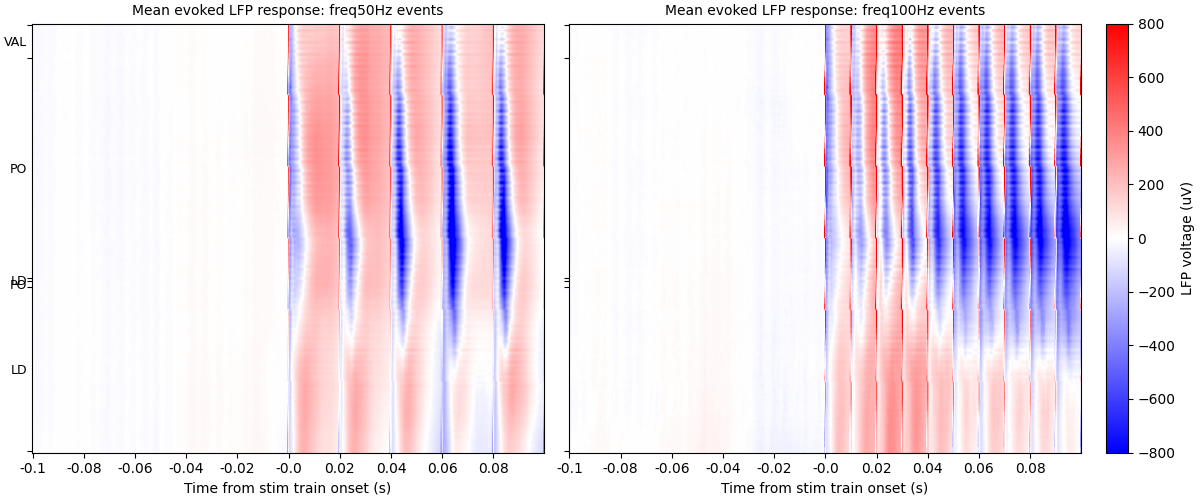

In [30]:
compare = ['freq50Hz', 'freq100Hz']
vlevel = 800

## get area labels ##
area_boundaries = []
area_labels = []
last_area = ''
for ai, area in enumerate(probe_areas[THchs]):
    if area != last_area:
        area_boundaries.append(ai)
        area_labels.append(area)
        last_area = area
area_boundaries.append(ai)
label_locs = area_boundaries[:-1] + np.diff(area_boundaries)/2

fig, axs = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)
for ax, freq in zip(axs.flatten(), compare):
    traininds = np.nonzero(simple_log['stim_type'].values == freq)[0]
    mean_LFPEP = np.mean(baselinesub_LFP[traininds, :, :], axis=0)
    lfpim = ax.imshow(mean_LFPEP.T, interpolation=None, cmap='bwr', aspect='auto', vmin=-vlevel, vmax=vlevel)
    ax.set_title('Mean evoked LFP response: {} events'.format(freq))
    ax.set_xticks(np.arange(0, len(event_ts), 50))
    ax.set_xticklabels(np.round(event_ts[::50], 2))
    ax.set_xlabel('Time from stim train onset (s)')
axs[0].set_yticks(area_boundaries)
axs[0].set_yticklabels('')
axs[0].set_yticks(label_locs, minor=True)
axs[0].set_yticklabels(area_labels, minor=True, fontsize=9)
axs[0].tick_params(which='minor', length=0)
axs[1].set_yticks(area_boundaries)
axs[1].set_yticklabels('')
fig.colorbar(lfpim, ax=axs[1], label='LFP voltage (uV)')

### SAVE ###
fig_name = '{}{}_TH-LFP_meanEP.png'.format(exp.mouse, exp_tag)
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

In [33]:
chi = 30
lfp_ch = lfp_data_mm[:, chi] * exp.ephys_params[probe_name]['bit_volts']

stim_type      freq50Hz
parameter            70
duration             20
onset        2616.89479
offset       2636.89491
sweep                 0
Name: 8, dtype: object


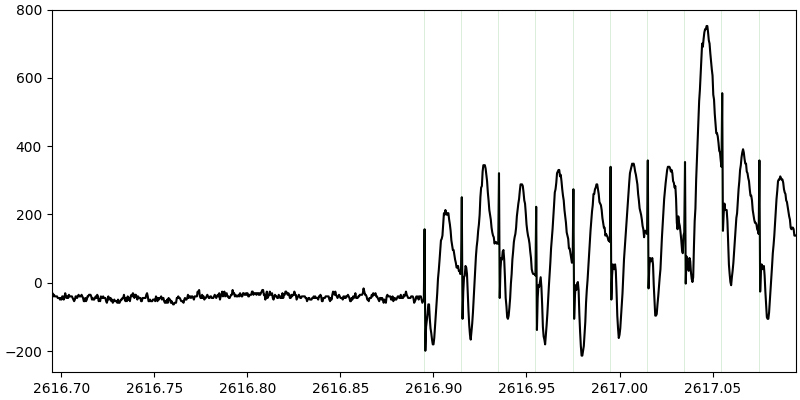

In [47]:
choose_event = 8
eventrow = simple_log.iloc[choose_event]
print(eventrow)
event_stims = stim_log[stim_log['event_ID'] == choose_event]

pdelta = [-0.2, 0.2] # plot before and after, s
pwindow = [eventrow.onset + pdelta[0], eventrow.onset + pdelta[1]]

timeinds = np.nonzero((lfp_ts > pwindow[0]) & (lfp_ts < pwindow[1]))[0]

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
ax.plot(lfp_ts[timeinds], lfp_ch[timeinds], color='k')
ax.set_xlim(pwindow)
for si, stimi in event_stims.iterrows():
    ax.axvline(stimi.onset, color='g', linewidth=0.5, alpha=0.2)